In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
sys.path.append('../')
from Scattering_Simulator import pairwise_method
from scipy import integrate
import matplotlib.cm as cm
from scipy.spatial.transform import Rotation as R
from gsd import hoomd
from scipy.interpolate import BSpline, splrep
from scipy.signal import savgol_filter
import os

## HOOMD-blue to SAXS
The purpose of this notebook is to convert HOOMD-blue simulations into SAXS curves that are directly comparble to SAXS data obtained experimentally. This is done first by extracting the positions and orientations of objects from the HOOMD-blue simulation file (.gsd file) and creating a model of the object being simulated (e.g., spheres, cubes). Then this information is used with the MC-DFM to simulate the scattering curve at any frame of the simulation. The following section is used to read the .gsd file and extract the positions and orientations. 

In [2]:
def extract_positions_orientations(filename):
    """
    Extract positions and orientations from each frame of a GSD file.

    Parameters
    ----------
    filename : str
        Path to the GSD trajectory file.

    Returns
    -------
    positions : list of np.ndarray
        List of arrays of shape (N, 3) with particle positions per frame.
    orientations : list of np.ndarray or None
        List of arrays of shape (N, 4) with quaternions per frame,
        or None if not present in the frame.
    """
    traj = hoomd.open(name=filename, mode='r')

    positions = []
    orientations = []

    for frame in traj:
        positions.append(frame.particles.position.copy())

        if hasattr(frame.particles, 'orientation'):
            orientations.append(frame.particles.orientation.copy())
        else:
            orientations.append(None)

    return positions, orientations


def quaternion_to_euler(quat, degrees=True, order='xyz'):
    """
    Convert a quaternion (HOOMD format: [qw, qx, qy, qz]) to Euler angles.

    Parameters:
    - quat: array-like, quaternion [qw, qx, qy, qz]
    - degrees: bool, return angles in degrees if True (default), radians if False
    - order: str, axes sequence for Euler angles ('xyz', 'zyx', etc.)

    Returns:
    - tuple of 3 Euler angles (angle_x, angle_y, angle_z)
    """
    # Convert to scipy format (qx, qy, qz, qw)
    #scipy_quat = [quat[1], quat[2], quat[3], quat[0]]
    scipy_quat = quat
    r = R.from_quat(scipy_quat)
    angles = r.as_euler(order, degrees=degrees)
    return angles

In [3]:
file_path = '../Data/HOOMD/randomized_cube_assembly513203244.gsd' #This is the path to the .gsd file 

In [4]:
positions, orientations = extract_positions_orientations(file_path)
print(f"Number of frames: {len(positions)}")
print("First frame position shape:", positions[0].shape)
print("First frame orientation shape:", orientations[0].shape if orientations[0] is not None else "Not available")

Number of frames: 60
First frame position shape: (7200, 3)
First frame orientation shape: (7200, 4)


In [5]:
# in the cubes simulation, we approximate a cube with a center sphere and 8 spheres surrounding it. To extract the position and orientation of only the center sphere, we need to specify how many center spheres there are in the simulation 
Number_of_Cubes = 800

In [6]:
orientations_euler = []
for i in range(len(orientations)):
    angles = quaternion_to_euler(orientations[i][:Number_of_Cubes, :]) 
    orientations_euler.append(angles)

lattice_coordinates = []
for i in range(len(orientations_euler)):
    lattice_coordinates.append(np.hstack((positions[i][:Number_of_Cubes, :], orientations_euler[i][:Number_of_Cubes, :])))

## Building Block 
The building block is defined as the object being simulated such as a sphere or cube. This is not saved in the .gsd file so we need to create this object here. 

In [7]:
def grid_points_in_sphere(D, spacing):
    """
    Generate a regular 3D grid of points spaced by 'spacing' that fit inside a sphere.

    Parameters
    ----------
    D : float
        Diameter of the sphere.
    spacing : float
        Distance between adjacent grid points.

    Returns
    -------
    points : np.ndarray of shape (M, 3)
        Grid points inside the sphere.
    """
    radius = D / 2.0
    r2 = radius ** 2

    # Create a 3D grid
    coords = np.arange(-radius, radius + spacing, spacing)
    X, Y, Z = np.meshgrid(coords, coords, coords)
    grid = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T

    # Keep only the points inside the sphere
    mask = np.sum(grid**2, axis=1) <= r2
    points = grid[mask]

    return points


def fill_cube_with_points(N, edge_length):
    """
    Fill a cube with N points approximately uniformly distributed.

    Parameters
    ----------
    N : int
        Number of points to place inside the cube.
    edge_length : float
        Length of each edge of the cube.

    Returns
    -------
    points : np.ndarray of shape (N, 3)
        Coordinates of the points inside the cube.
    """
    # Estimate number of points per side of the grid
    n_side = int(np.ceil(N ** (1/3)))
    spacing = edge_length / n_side

    # Create grid
    coords = np.linspace(-edge_length / 2 + spacing / 2,
                          edge_length / 2 - spacing / 2,
                          n_side)

    X, Y, Z = np.meshgrid(coords, coords, coords)
    grid = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T

    # Select only the first N points
    points = grid[:N]

    return points

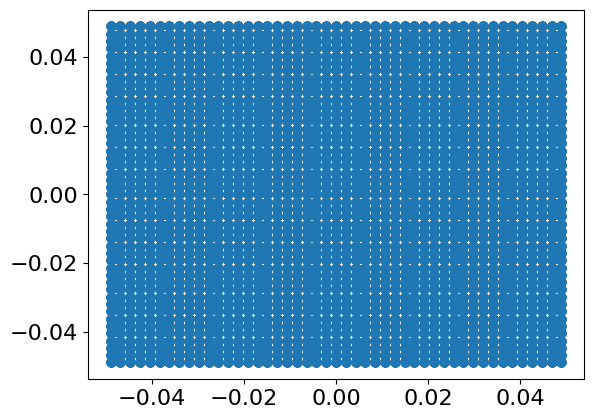

In [11]:
#Sphere
# D = 0.5       # diameter of the sphere
# spacing = 0.003 # spacing between grid points
# points = grid_points_in_sphere(D, spacing)

#Cube
points = fill_cube_with_points(N=100000, edge_length=0.1)

ones = np.array([1]*len(points))
points = np.hstack((points, ones.reshape(-1,1)))
plt.scatter(points[:,0], points[:,2])
plt.show()

## Calculate the Scattering curve 
This next section reads the positions and orientations from the simulation frames of the .gsd file and calculates the scattering curve of the specified frame. 

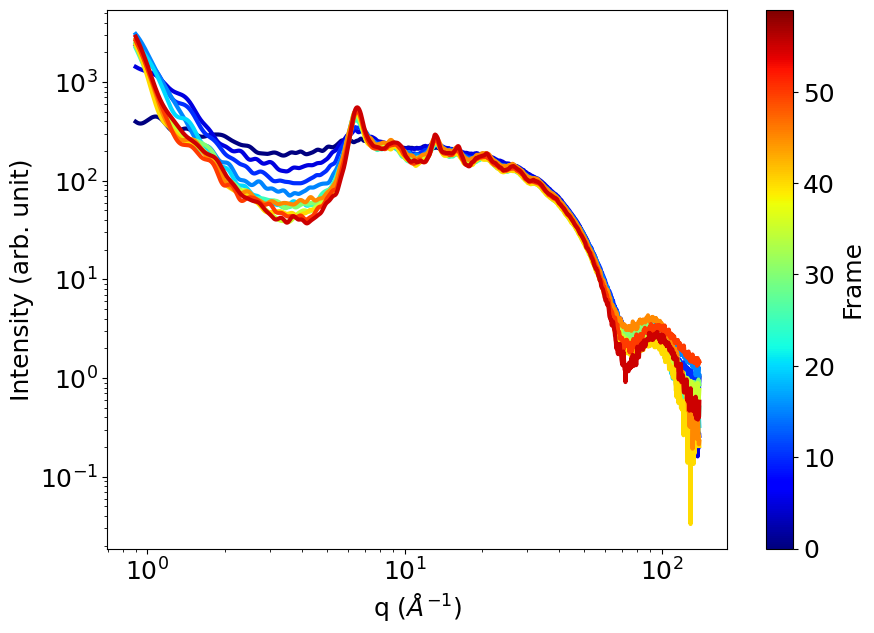

In [12]:

################################## INPUTS ##########################################################################################

plot_every_n_frame = 5            # Determines how many SAXS simulations occur per frame  
histogram_bins = 10000            # Number of bins in the pairwise distribution calculation 
q = np.geomspace(0.9, 140, 2000)  # SAXS q-range to be calculated
path = '../Data/HOOMD/core_shell_cube_assembly_0.1_edge_length/assembly_2/'  # Where to save the files and plot

####################################################################################################################################

frames = len(positions)
cmap = cm.jet
norm = plt.Normalize(0, frames - 1)
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(10,7))

for i in range(frames):
    if i%plot_every_n_frame == 0:
        n_samples = 5000000
        simulator = pairwise_method.scattering_simulator(n_samples)
        simulator.sample_building_block(points)
        simulator.sample_lattice_coordinates(lattice_coordinates[i])
        simulator.calculate_structure_coordinates()
        # I_q = simulator.simulate_multiple_scattering_curves_lattice_coords(points, lattice_coordinates[i], histogram_bins, q, save=False).numpy()
        # I_q = np.mean(I_q, axis=1)
        I_q = simulator.simulate_scattering_curve_fast_lattice(points, lattice_coordinates[i], histogram_bins, q, save=False).numpy()
        plt.rcParams.update({'font.size': 18})        
        ax.plot(q, I_q, color=cmap(norm(i)), linewidth = 3, label = '10m Sample Size')
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylabel('Intensity (arb. unit)')
        ax.set_xlabel('q ($\\AA^{-1}$)')
        #plt.legend(fontsize=14)
        data = np.hstack((q.reshape(-1,1), I_q.reshape(-1,1)))
        #np.save(path + scattering_curve_' + str(i) + '.npy', data)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) 
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Frame')
#plt.savefig(path + scattering_curve_plot.png', dpi=600, bbox_inches="tight")

## Simulation object

This section plots the simulation object of the last frame from the .gsd file and can be used as a way to check if the simulated object matches the expected one. The simulation object is made up of the randomly selected pariwise distances that were used to calculate the scattering curve. 

Text(0, 0.5, 'y - direction')

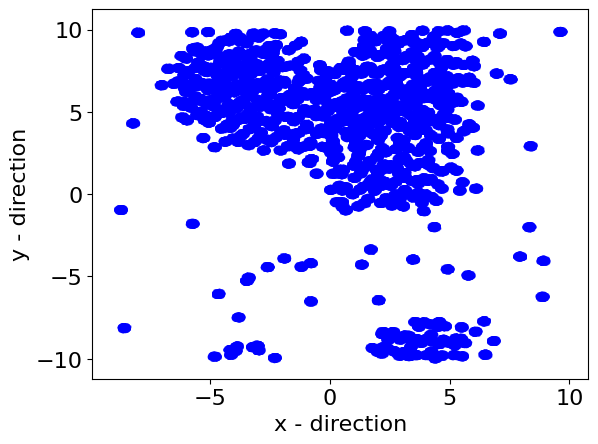

In [10]:
struc = simulator.structure_coordinates_1
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots()
ax.scatter(struc[:,0], struc[:,1], alpha = 0.25, s=1, color = 'blue')
ax.set_xlabel('x - direction')
ax.set_ylabel('y - direction')

the same plot in another perspective

Text(0, 0.5, 'z - direction')

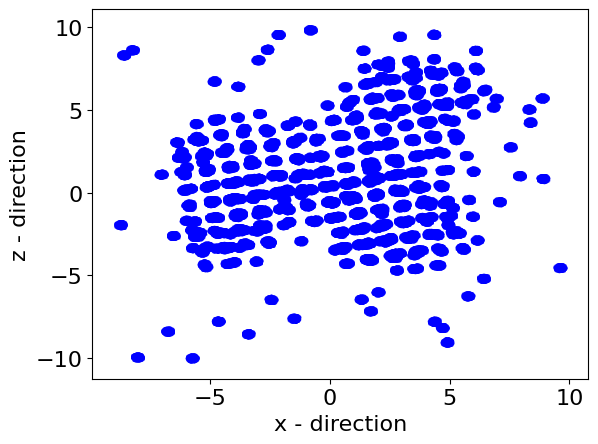

In [64]:
struc = simulator.structure_coordinates_1
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots()
ax.scatter(struc[:,0], struc[:,2], alpha = 0.25, s=1, color = 'blue')
ax.set_xlabel('x - direction')
ax.set_ylabel('z - direction')

## HOOMD Simulation Code
This code was used to create the sphere assemblies. It will only work with HOOMD installed. 

In [ ]:
import hoomd
import hoomd.md
import hoomd.write.gsd
import numpy as np
from scipy.spatial.transform import Rotation
import time

def simulation(sim_duration):
    # --- Initialize device and simulation ---
    device = hoomd.device.CPU()
    sim = hoomd.Simulation(device=device, seed=42)

    # --- Parameters ---
    N_cubes = 800
    density = 0.8
    cube_length = 1.0
    sphere_diameter = 0.3
    particles_per_cube = 8
    child_type = 'B'
    spacing_buffer = 1.2

    # Define cube vertex offsets (2x2x2 cube)
    offsets = []
    for x in [-0.25, 0.25]:
        for y in [-0.25, 0.25]:
            for z in [-0.25, 0.25]:
                offsets.append([x * cube_length, y * cube_length, z * cube_length])
    offsets = np.array(offsets)

    # Estimate box size
    volume_per_cube = (cube_length * 2) ** 3
    box_length = (N_cubes * volume_per_cube / density) ** (1 / 3)

    # Random cube placement with orientation, avoiding overlap
    def random_rotation():
        angle = np.random.normal(0, 0.2)
        axis = np.random.normal(0, 1, 3)
        axis /= np.linalg.norm(axis)
        return Rotation.from_rotvec(angle * axis)

    positions = []
    orientations = []
    min_dist = (cube_length + sphere_diameter) * spacing_buffer
    attempts = 0
    max_attempts = 10000

    while len(positions) < N_cubes and attempts < max_attempts:
        candidate = np.random.uniform(-box_length / 2 + cube_length,
                                    box_length / 2 - cube_length, size=3)
        if all(np.linalg.norm(candidate - p) > min_dist for p in positions):
            positions.append(candidate)
            orientations.append(random_rotation())
        attempts += 1

    if len(positions) < N_cubes:
        raise RuntimeError("Failed to place non-overlapping cubes.")

    # Generate constituent particle positions
    all_positions = []
    typeid = []
    body = []

    for i, (center, rot) in enumerate(zip(positions, orientations)):
        for offset in offsets:
            rotated = rot.apply(offset)
            all_positions.append(center + rotated)
            typeid.append(0)  # only 'B'
            body.append(i)

    # --- Create snapshot with rigid parents ---
    # Convert scipy rotations to quaternions for 'A' particle orientation
    parent_orientations = [rot.as_quat() for rot in orientations]  # (x, y, z, w)
    parent_positions = positions
    parent_typeid = [1] * N_cubes  # 'A'
    parent_body = list(range(N_cubes))

    # Shift child particle body indices to follow the parent
    all_positions = parent_positions + all_positions
    all_typeid = parent_typeid + typeid
    all_body = parent_body + body

    snapshot = hoomd.Snapshot()
    snapshot.particles.N = len(all_positions)
    snapshot.particles.types = ['B', 'A']
    snapshot.particles.position[:] = all_positions
    snapshot.particles.typeid[:] = all_typeid
    snapshot.particles.body[:] = all_body
    snapshot.particles.diameter[:] = [sphere_diameter] * len(all_positions)
    snapshot.particles.mass[:] = [1.0] * N_cubes + [0.0] * (len(all_positions) - N_cubes)
    snapshot.particles.orientation[:] = [tuple(q[[3, 0, 1, 2]]) for q in parent_orientations] + [(1, 0, 0, 0)] * (snapshot.particles.N - N_cubes)
    snapshot.configuration.box = [box_length, box_length, box_length, 0, 0, 0]

    sim.create_state_from_snapshot(snapshot)

    # --- Define rigid bodies ---
    rigid = hoomd.md.constrain.Rigid()
    rigid.body['A'] = {
        "constituent_types": ['B'] * len(offsets),
        "positions": offsets.tolist(),
        "orientations": [(1, 0, 0, 0)] * len(offsets)
    }
    sim.operations.add(rigid)


    # --- Lennard-Jones interactions ---
    nl = hoomd.md.nlist.Cell(buffer=0.4)
    lj = hoomd.md.pair.LJ(nlist=nl)
    lj.params[('B', 'B')] = dict(epsilon=5.0, sigma=0.45)
    lj.params[('A', 'A')] = dict(epsilon=0.0, sigma=1.0)
    lj.params[('A', 'B')] = dict(epsilon=0.0, sigma=1.0)
    lj.params[('B', 'A')] = dict(epsilon=0.0, sigma=1.0)
    lj.r_cut[('B', 'B')] = 3.0 * 0.45
    lj.r_cut[('A', 'A')] = 1.0
    lj.r_cut[('A', 'B')] = 1.0
    lj.r_cut[('B', 'A')] = 1.0

    # --- Integrator ---
    from hoomd.md.methods import Langevin

    integrator = hoomd.md.Integrator(dt=0.002, integrate_rotational_dof=True)
    integrator.rigid = rigid
    langevin = Langevin(filter=hoomd.filter.Rigid(), kT=0.2)
    langevin.gamma['A'] = 1.0
    langevin.gamma_r['A'] = (1.0, 1.0, 1.0)
    integrator.methods.append(langevin)
    integrator.forces.append(lj)
    sim.operations.integrator = integrator

    # --- Finalize setup, then initialize momenta ---
    sim.run(1)
    sim.state.thermalize_particle_momenta(filter=hoomd.filter.Rigid(), kT=0.2)

    sec = time.localtime().tm_sec
    min = time.localtime().tm_min
    hour = time.localtime().tm_hour
    day = time.localtime().tm_mday
    month = time.localtime().tm_mon
    timestamp = str(month) + str(day) + str(hour) +  str(min) + str(sec)

    # --- Output trajectory ---
    gsd_writer = hoomd.write.gsd.GSD(
        filename='randomized_cube_assembly' + timestamp + '.gsd',
        trigger=hoomd.trigger.Periodic(1000),
        mode='wb'
    )
    sim.operations.writers.append(gsd_writer)

    # --- Run the simulation with annealing ---
    # Stage 1: high temperature
    langevin.kT = 10
    sim.state.thermalize_particle_momenta(filter=hoomd.filter.Rigid(), kT=10)
    sim.run(sim_duration)

    # Stage 2: intermediate temperature
    langevin.kT = 9.5
    sim.state.thermalize_particle_momenta(filter=hoomd.filter.Rigid(), kT=9.5)
    sim.run(sim_duration)

    # Stage 3: final low temperature
    langevin.kT = 10.5
    sim.state.thermalize_particle_momenta(filter=hoomd.filter.Rigid(), kT=9.0)
    sim.run(sim_duration)

    # Stage 3: final low temperature
    langevin.kT = 9.5
    sim.state.thermalize_particle_momenta(filter=hoomd.filter.Rigid(), kT=9.5)
    sim.run(sim_duration)

    # Stage 3: final low temperature
    langevin.kT = 10.5
    sim.state.thermalize_particle_momenta(filter=hoomd.filter.Rigid(), kT=9.0)
    sim.run(sim_duration)

    # Stage 3: final low temperature
    langevin.kT = 9
    sim.state.thermalize_particle_momenta(filter=hoomd.filter.Rigid(), kT=9)
    sim.run(sim_duration)